# CLIP Inversion

In [1]:
# !pip -q install open_clip_torch datasets

In [2]:
import open_clip
import math, torch
import torch.nn as nn
from torch.nn import init
from tqdm.auto import tqdm
import torch.nn.functional as F
from matplotlib import pyplot as plt
from einops import rearrange, repeat

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
# !pip install hf_transfer; export HF_HUB_ENABLE_HF_TRANSFER=True; huggingface-cli download --repo-type dataset cloneofsimo/imagenet.int8 --local-dir ./vae_mds

In [5]:
# !pip install mosaicml-streaming

In [6]:
from streaming.base.format.mds.encodings import Encoding, _encodings
import numpy as np
from typing import Any
import torch
from streaming import StreamingDataset

class uint8(Encoding):
    def encode(self, obj: Any) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes) -> Any:
        x=  np.frombuffer(data, np.uint8).astype(np.float32)
        return (x / 255.0 - 0.5) * 24.0

_encodings["uint8"] = uint8

remote_train_dir = "./vae_mds" # this is the path you installed this dataset.
local_train_dir = "./local_train_dir"

train_dataset = StreamingDataset(
    local=local_train_dir,
    remote=remote_train_dir,
    split=None,
    shuffle=True,
    shuffle_algo="naive",
    num_canonical_nodes=1,
    batch_size = 32
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=3,
)

In [7]:
from diffusers.models import AutoencoderKL
from diffusers.image_processor import VaeImageProcessor
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to(device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


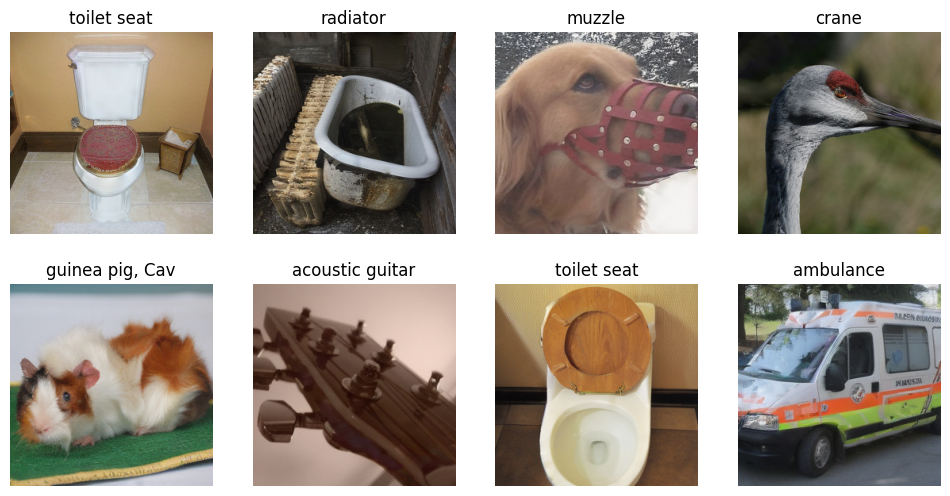

In [8]:
batch = next(iter(train_dataloader))
latents = batch['vae_output'].reshape(-1, 4, 32, 32).to(device)
labels = batch['label_as_text']
with torch.no_grad():
  x = vae.decode(latents[:8].cuda()).sample
  imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*8)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, im in enumerate(imgs):
  axs[i // 4,  i % 4].imshow(im)
  axs[i // 4,  i % 4].axis('off')
  axs[i // 4,  i % 4].set_title(labels[i][:15])

In [9]:
latents.shape

torch.Size([32, 4, 32, 32])

# Open CLIP Model

In [10]:
# (‘ViT-B-32’ keeps the spatial grid small (7×7) so the decoder can stay tiny)
clip_model_name        = "ViT-B-32"
pretrained_tag    = "laion2b_s34b_b79k"      # any tag shown by open_clip.list_pretrained()
clip_model, _, preprocess = open_clip.create_model_and_transforms(
        clip_model_name, pretrained=pretrained_tag, device="cuda")
clip_model.eval();

In [11]:
def get_patch_tokens(img_batch, layer: int | None = None, fmt: str = 'NCHW'):
    """
    img_batch : (B, 3, 224, 224)  – pre-processed
    layer     : None → final ViT block;
                int  → zero-indexed block
                -k   → kth block from the end (e.g. -3 → third-to-last)
    fmt       : 'NCHW' or 'NLC'  (see open-clip docs)

    Returns   : patch tokens *without* the class token, shape
                (B, 49, D) if fmt=='NLC'  – handy for reshaping to 7×7
                (B, D, 7, 7) if fmt=='NCHW' – ready for deconv
    """
    v = clip_model.visual                                    # vision tower
    n_blocks = len(v.transformer.resblocks)

    # Normalise Python negative-index semantics
    if layer is None:
        layer = n_blocks - 1
    elif layer < 0:
        layer = n_blocks + layer
    assert 0 <= layer < n_blocks, f"layer idx must be in [0,{n_blocks-1}]"

    # forward_intermediates returns *lists* whose order mirrors indices arg
    out = v.forward_intermediates(
        img_batch,
        indices=[layer],            # single block
        output_fmt=fmt,             # 'NCHW' keeps spatial layout for us
        output_extra_tokens=True    # gives class-token in a separate key
    )

    toks = out['image_intermediates'][0]    # first (only) requested layer

    return toks

# quick sanity-check:
with torch.no_grad():
    sample = torch.randn(1,3,224,224).cuda()
    z = get_patch_tokens(sample, layer=-1, fmt="NLC")
    print(z.shape)

torch.Size([1, 49, 768])


In [12]:
def clip_embeds_from_batch(batch, layer=-3, fmt="NLC"):
  latents = batch['vae_output'].reshape(-1, 4, 32, 32).to(device)
  labels = batch['label_as_text']
  with torch.no_grad():
    x = vae.decode(latents.cuda()).sample
    imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*latents.shape[0])
    imgs = torch.stack([preprocess(image.convert("RGB")) for image in imgs]).to(device)
    tokens  = get_patch_tokens(imgs, layer=layer, fmt=fmt)
  return tokens

tokens = clip_embeds_from_batch(next(iter(train_dataloader)))
tokens.shape

torch.Size([32, 49, 768])

# DiT

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Expected types for id2label: (typing.Dict[int, str], <class 'NoneType'>), got typing.Dict[str, str].


  0%|          | 0/25 [00:00<?, ?it/s]

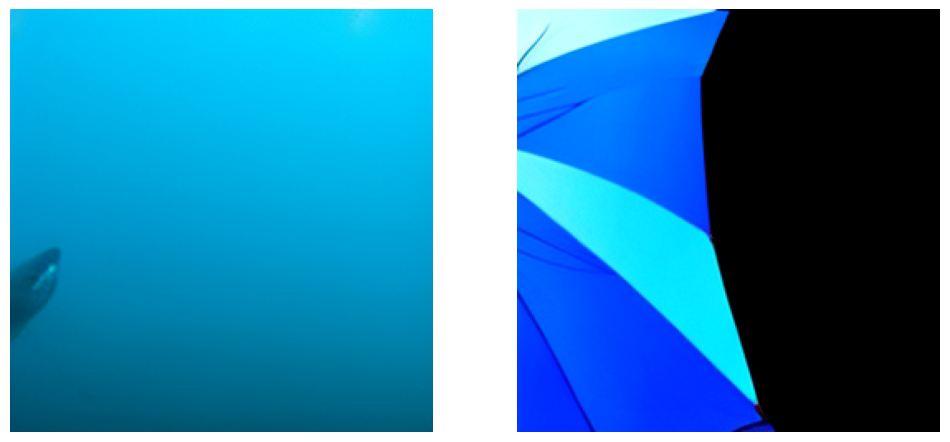

In [13]:
from diffusers import DiTPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiTPipeline.from_pretrained("facebook/DiT-XL-2-256", torch_dtype=torch.float32)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# pick words from Imagenet class labels
pipe.labels  # to print all available words

# pick words that exist in ImageNet
words = ["white shark", "umbrella"]

class_ids = pipe.get_label_ids(words)

generator = torch.manual_seed(33)
output = pipe(class_labels=class_ids, num_inference_steps=25, generator=generator)

# Show the two images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, im in enumerate(output.images):
  axs[i].imshow(im)
  axs[i].axis('off')

In [14]:
import torchvision
def imgs_to_pipe_latents(imgs):
  # Images to tensors
  tfm = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
  ])
  imgs = torch.stack([tfm(image.convert("RGB"))*2-1 for image in imgs]).to(device)
  # Encode with vae
  with torch.no_grad():
    latents = pipe.vae.encode(imgs.to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)).latent_dist.sample()
  return latents

latents = imgs_to_pipe_latents(output.images)
latents.shape

torch.Size([2, 4, 32, 32])

In [15]:
pipe.transformer.train();

In [16]:
def new_fwd(self, hidden_states, c, timestep):
  height, width = hidden_states.shape[-2] // self.patch_size, hidden_states.shape[-1] // self.patch_size
  hidden_states = self.pos_embed(hidden_states)
  l = hidden_states.shape[1]
  hidden_states = torch.cat([self.cond_embed(c), hidden_states], dim=1)
  cls = torch.ones(hidden_states.shape[0]).int().to(device)
  for block in self.transformer_blocks:
    hidden_states = block(
        hidden_states,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        timestep=timestep,
        class_labels=cls
    )
  conditioning = self.transformer_blocks[0].norm1.emb(timestep, cls, hidden_dtype=hidden_states.dtype)
  shift, scale = self.proj_out_1(F.silu(conditioning)).chunk(2, dim=1)
  hidden_states = self.norm_out(hidden_states) * (1 + scale[:, None]) + shift[:, None]
  hidden_states = self.proj_out_2(hidden_states)
  hidden_states = hidden_states[:, -l:]
  height = width = int(l ** 0.5)
  hidden_states = hidden_states.reshape(
      shape=(-1, height, width, self.patch_size, self.patch_size, self.out_channels)
  )
  hidden_states = torch.einsum("nhwpqc->nchpwq", hidden_states)
  output = hidden_states.reshape(
      shape=(-1, self.out_channels, height * self.patch_size, width * self.patch_size)
  )
  return output

In [17]:
pipe.transformer.cond_embed = nn.Linear(768, 1152).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)

In [18]:
# Sanity check
B, C, H = 2, 4, 32
img = torch.randn(B, C, H, H).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
t = torch.randint(0, 1000, (B,)).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
c = torch.randn((B, 49, 768)).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
out = new_fwd(pipe.transformer, img, c, t)
print(out.shape)       # (B,C,H,H)

torch.Size([2, 8, 32, 32])


In [19]:
pipe.transformer.out_channels # 8 out, for learned sigma or somethiong, we're just gonna take the first 4 :shrug:

8

In [20]:
opt = torch.optim.AdamW(pipe.transformer.parameters(), lr=6e-5)
losses = []

# First batch for eval:
eval_batch = next(iter(train_dataloader))
eval_bs=eval_batch['vae_output'].shape[0]
eval_t = torch.arange(0, 1, step=1/eval_bs).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
eval_x = eval_batch['vae_output'].reshape(-1, 4, 32, 32).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
eval_c =  clip_embeds_from_batch(eval_batch).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
eval_t_expanded = eval_t.view([eval_bs, *([1] * len(eval_x.shape[1:]))]).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
eval_z1 = torch.randn(eval_x.shape).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
eval_z_t = (1 - eval_t_expanded) * eval_x + eval_t_expanded * eval_z1
eval_losses = []

for i, batch in tqdm(enumerate(train_dataloader), total=1000): #len(train_dataloader)):

  x = batch['vae_output'].reshape(-1, 4, 32, 32)
  # decode latent x to images with SDXL
  with torch.no_grad():
    imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*x.shape[0])
  # Encode with pipe's vae
  with torch.no_grad():
    x = imgs_to_pipe_latents(imgs)
    x *= pipe.vae.config.scaling_factor

  # Get clip embeds
  c = clip_embeds_from_batch(batch).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)

  # Inspired by auraflow
  b = x.size(0)
  t = torch.rand((b,)).to(device)
  tint = (t*1000).int()
  t_expanded = t.view([b, *([1] * len(x.shape[1:]))]).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
  z_1 = torch.randn(x.shape).to(device, dtype = pipe.vae.encoder.conv_in.weight.dtype)
  z_t = (1 - t_expanded) * x + t_expanded * z_1
  vtheta = new_fwd(pipe.transformer, z_t, c=c, timestep=tint)[:, :4]  # predict z_1 - x.
  loss = ((z_1 - x - vtheta) ** 2).mean()
  # Skipping TV loss etc
  opt.zero_grad()
  loss.backward()
  opt.step()
  losses.append(loss.item())

  if i % 100 == 0:
    with torch.no_grad():
      eval_vtheta = new_fwd(pipe.transformer, eval_z_t, eval_c, (eval_t*1000).int())[:, :4]
      eval_loss = ((eval_z1 - eval_x - eval_vtheta) ** 2).mean()
      print(f"most recent eval loss: {eval_loss.item()} (train loss {losses[-1]})")
      eval_losses.append(eval_loss.item())

  if i > 10000: break # Optional early stop

  0%|          | 0/1000 [00:00<?, ?it/s]

most recent eval loss: 44.768463134765625 (train loss 2.5261456966400146)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1018.88 MiB is free. Process 600178 has 38.55 GiB memory in use. Of the allocated memory 17.43 GiB is allocated by PyTorch, and 20.62 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
??pipe.__call__

In [ ]:
def sample(model,  z, c, sample_steps=50, cfg=2.0):
  with torch.no_grad():
    # Simple ODE sampling
    b = z.size(0)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt] * b).to(z.device).view([b, *([1] * len(z.shape[1:]))])
    images = [z]
    for i in range(sample_steps, 0, -1):
      t = i / sample_steps
      t = torch.tensor([t] * b).to(z.device).clip(0, 0.999) # Can't handle 1 in tembed
      vc = new_fwd(pipe.transformer, z, c, (t*1000).int())[:, :4]
      z = z - dt * vc
      images.append(z)
    return images

In [ ]:
c = clip_embeds_from_batch(eval_batch).to(device)[:8]
labels = eval_batch['label_as_text'][:8]
z = torch.randn(8, 4, 32, 32).to(device)
samples = sample(pipe.transformer, z, c, sample_steps=50)

In [ ]:
with torch.no_grad():
  x = (1 / pipe.vae.config.scaling_factor) * samples[-1]
  x = pipe.vae.decode(x).sample

  x = (x / 2 + 0.5).clamp(0, 1)

  # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
  x = x.cpu().permute(0, 2, 3, 1).float().numpy()

  x = pipe.numpy_to_pil(x)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, im in enumerate(x):
  axs[i // 4,  i % 4].imshow(im)
  axs[i // 4,  i % 4].axis('off')
  axs[i // 4,  i % 4].set_title(labels[i][:15])
plt.show()

In [ ]:
plt.plot(losses, label='train')
plt.plot(eval_losses, label='eval')
plt.legend();